In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff5511; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,time,copy,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils,models
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(d):
    if d=='1': loaders=dataloaders
    if d=='2': loaders=dataloaders2
    for images,labels in loaders['valid']:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        images=np.transpose(images,(0,2,3,1))/2.+.5
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break

In [6]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [7]:
dhtml('Data')

In [8]:
img_size=128
classes=('plane','car','bird','cat','deer',
          'dog','frog','horse','ship','truck')
random_seed=12; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=trans)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=trans)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size), 
             'valid':tdl(dataset=valid,shuffle=True, 
                         batch_size=batch_size),
             'test':tdl(dataset=test,shuffle=True, 
                        batch_size=batch_size)}

Files already downloaded and verified


Image dimensions: torch.Size([128, 3, 128, 128])
Label dimensions: torch.Size([128])


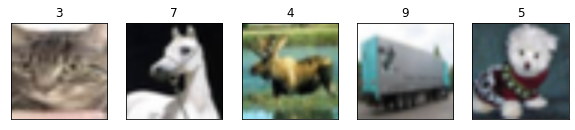

In [9]:
%display_examples 1

In [10]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')
x=timage.resize(x,[img_size,img_size])/255
x=2*np.transpose(x.numpy(),(0,3,1,2))-1
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
dataloaders2={'train':tdl(dataset=train2,shuffle=True, 
                          batch_size=batch_size), 
              'valid':tdl(dataset=valid2,shuffle=True, 
                          batch_size=batch_size),
              'test':tdl(dataset=test2,shuffle=True, 
                         batch_size=batch_size)}

['backgrounds', 'images', 'labels']
0.18010321 0.27663812


Image dimensions: torch.Size([128, 3, 128, 128])
Label dimensions: torch.Size([128])


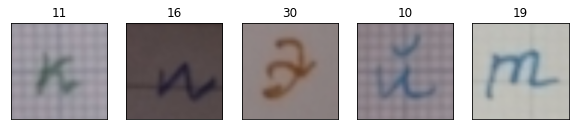

In [11]:
%display_examples 2

In [12]:
dhtml('VGG16')

In [13]:
model=models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad=False

In [14]:
model.classifier[3].requires_grad=True
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
dhtml('Training')

In [16]:
@register_line_magic
def train_run(pars):
    [epochs,n]=pars.split()
    epochs=int(epochs); n=int(n)
    if n==1: loaders=dataloaders
    if n==2: loaders=dataloaders2
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) \
        in enumerate(loaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids,
                         len(loaders['train']),cost))
        model.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d'%(epoch+1,epochs))
            print('train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(model,loaders['train']),
                   epoch_loss(model,loaders['train']),
                   model_acc(model,loaders['valid']),
                   epoch_loss(model,loaders['valid'])))

In [17]:
num_classes=10
model.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters())

In [18]:
%train_run 3 1

Epoch: 001/003 | Batch: 000/344 | Cost: 2.3096
Epoch: 001/003 | Batch: 100/344 | Cost: 0.7992
Epoch: 001/003 | Batch: 200/344 | Cost: 0.7600
Epoch: 001/003 | Batch: 300/344 | Cost: 0.8505
Epoch: 001/003
train acc/loss: 80.65%/0.55 valid acc/loss: 79.25%/0.59
Epoch: 002/003 | Batch: 000/344 | Cost: 0.6974
Epoch: 002/003 | Batch: 100/344 | Cost: 0.6013
Epoch: 002/003 | Batch: 200/344 | Cost: 0.7207
Epoch: 002/003 | Batch: 300/344 | Cost: 0.6133
Epoch: 002/003
train acc/loss: 82.10%/0.52 valid acc/loss: 80.18%/0.57
Epoch: 003/003 | Batch: 000/344 | Cost: 0.7110
Epoch: 003/003 | Batch: 100/344 | Cost: 0.6311
Epoch: 003/003 | Batch: 200/344 | Cost: 0.6843
Epoch: 003/003 | Batch: 300/344 | Cost: 0.6070
Epoch: 003/003
train acc/loss: 83.38%/0.48 valid acc/loss: 80.67%/0.55


In [21]:
model=models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.classifier[3].requires_grad=True
num_classes=33
model.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,256),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(256,num_classes))
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters())

In [22]:
%train_run 3 2

Epoch: 001/003 | Batch: 000/089 | Cost: 3.5582
Epoch: 001/003
train acc/loss: 36.11%/2.34 valid acc/loss: 33.90%/2.39
Epoch: 002/003 | Batch: 000/089 | Cost: 2.6450
Epoch: 002/003
train acc/loss: 45.73%/2.00 valid acc/loss: 42.99%/2.07
Epoch: 003/003 | Batch: 000/089 | Cost: 2.3488
Epoch: 003/003
train acc/loss: 49.85%/1.81 valid acc/loss: 47.22%/1.89
